In [2]:
# ! pip install qiskit==1.2.4 qiskit-machine-learning==0.8.0 qiskit-algorithms==0.3.0 numpy pandas scikit-learn pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 10.2 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=357f77ab77fb0f77d44f4ad89733ff639f120f3a1597bd9c7d06f8f3cd97c547
  Stored in directory: /root/.cache/pip/whee

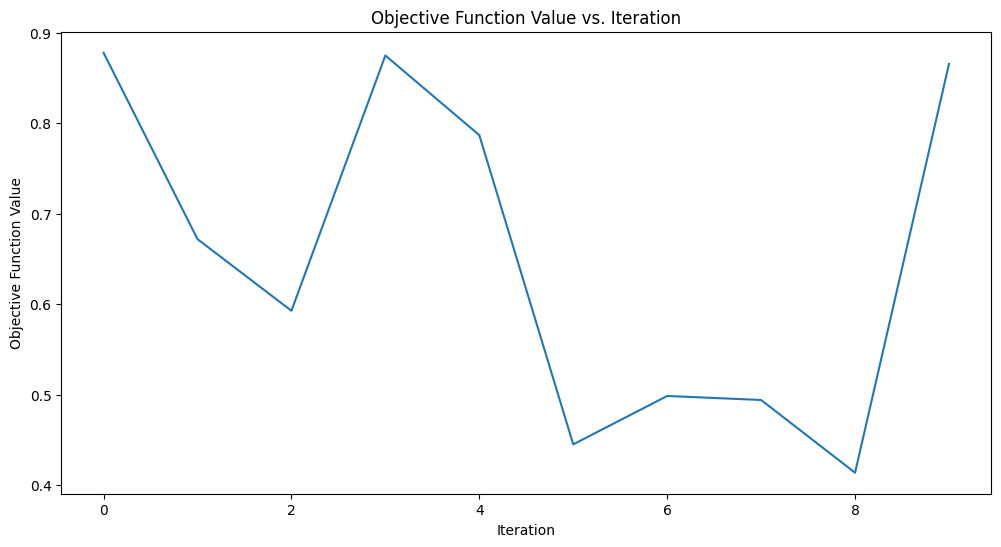

Test accuracy: 0.94
              precision    recall  f1-score   support

      BENIGN       0.96      0.97      0.97     68417
 Brute Force       0.00      0.00      0.00      2445

    accuracy                           0.94     70862
   macro avg       0.48      0.49      0.48     70862
weighted avg       0.93      0.94      0.94     70862



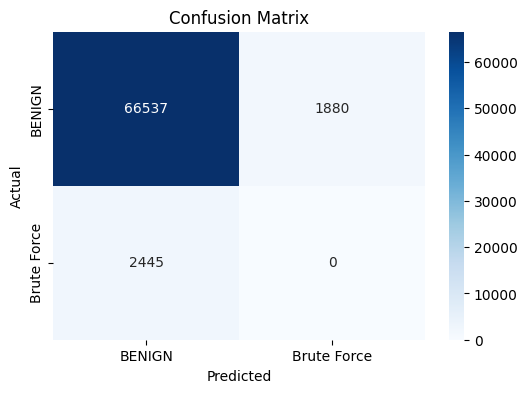

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import StatevectorSampler
from qiskit_machine_learning.algorithms import VQC
from qiskit_machine_learning.optimizers import COBYLA
from IPython.display import clear_output

# Initialize random seed for reproducibility
np.random.seed(42)

# Load Data
file_path = 'Tuesday-WorkingHours.pcap_ISCX.csv'
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()  # Remove whitespace from column names

# Debug: Check unique labels
print("Unique labels in raw data:", df['Label'].unique())

# Filter for BENIGN and Brute Force attacks
brute_force_labels = ['FTP-Patator', 'SSH-Patator']
df = df[df['Label'].isin(['BENIGN'] + brute_force_labels)]
df = df.dropna(subset=['Label'])  # Drop rows with NaN labels
print("Unique labels after filtering:", df['Label'].unique())

# Optional: Combine with Wednesday's data for more BENIGN samples
# Uncomment if you want to include Wednesday's BENIGN data
"""
wednesday_file_path = 'data/Wednesday-WorkingHours.pcap_ISCX.csv'
df_wednesday = pd.read_csv(wednesday_file_path)
df_wednesday.columns = df_wednesday.columns.str.strip()
df_wednesday = df_wednesday[df_wednesday['Label'] == 'BENIGN']
df_wednesday = df_wednesday.dropna(subset=['Label'])
df = pd.concat([df, df_wednesday], ignore_index=True)
print("Unique labels after combining with Wednesday:", df['Label'].unique())
"""

# Map labels: 0 for BENIGN, 1 for Brute Force
df['Label'] = df['Label'].map({'BENIGN': 0, 'FTP-Patator': 1, 'SSH-Patator': 1})
if df['Label'].isna().any():
    raise ValueError("Label mapping failed: NaN values detected")
print("Unique labels after mapping:", df['Label'].unique())

# Select 4 features
selected_features = ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd Packet Length Max']
X = df[selected_features].to_numpy()
y = df['Label'].to_numpy().flatten()  # Explicitly flatten to 1D
print(f"X shape: {X.shape}, y shape: {y.shape}, type: {type(y)}, unique y values: {np.unique(y)}, sample: {y[:5]}")

# Validate y is 1D and binary
if len(y.shape) != 1:
    raise ValueError(f"y is not 1D: shape {y.shape}")
if len(np.unique(y)) != 2:
    raise ValueError(f"y is not binary: unique values {np.unique(y)}")

# Normalize features to [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
y_train = y_train.flatten()  # Ensure 1D
y_test = y_test.flatten()  # Ensure 1D
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}, type: {type(y_train)}, unique: {np.unique(y_train)}, sample: {y_train[:5]}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}, type: {type(y_test)}, unique: {np.unique(y_test)}, sample: {y_test[:5]}")

# Validate y_train and y_test
if len(y_train.shape) != 1:
    raise ValueError(f"y_train is not 1D: shape {y_train.shape}")
if len(y_test.shape) != 1:
    raise ValueError(f"y_test is not 1D: shape {y_test.shape}")
if len(np.unique(y_train)) != 2:
    raise ValueError(f"y_train is not binary: unique values {np.unique(y_train)}")
if len(np.unique(y_test)) != 2:
    raise ValueError(f"y_test is not binary: unique values {np.unique(y_test)}")

# Subsample training data for faster quantum simulation
X_train, y_train = resample(X_train, y_train, n_samples=1000, random_state=42)
y_train = y_train.flatten()  # Ensure 1D after resampling
print(f"Subsampled X_train shape: {X_train.shape}, y_train shape: {y_train.shape}, type: {type(y_train)}, unique: {np.unique(y_train)}, sample: {y_train[:5]}")

# Validate subsampled y_train
if len(y_train.shape) != 1:
    raise ValueError(f"Subsampled y_train is not 1D: shape {y_train.shape}")
if len(np.unique(y_train)) != 2:
    raise ValueError(f"Subsampled y_train is not binary: unique values {np.unique(y_train)}")

# Define quantum components
feature_map = ZZFeatureMap(feature_dimension=4, reps=1)
ansatz = RealAmplitudes(num_qubits=4, reps=3)
optimizer = COBYLA(maxiter=10) #100 was a long time, graph converged at 50 last time
sampler = StatevectorSampler()

# Callback for plotting objective function
objective_func_vals = []
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.figure(figsize=(12, 6))
    plt.title("Objective Function Value vs. Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# Construct VQC
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    sampler=sampler,
    callback=callback_graph
)

# Train VQC
vqc.fit(X_train, y_train)

# Save Model
vqc.save('vqc_model.dill')

# Predict and evaluate
y_pred = vqc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.2f}")

# Classification report
print(classification_report(y_test, y_pred, target_names=['BENIGN', 'Brute Force']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['BENIGN', 'Brute Force'],
            yticklabels=['BENIGN', 'Brute Force'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()